In [95]:
import numpy as np
import matplotlib.pyplot as plt
import mujoco
import mediapy as media

from xmlMake import *
from Actuator import *
from optimization import *

from scipy.spatial.transform import Rotation as R

from arc_spline_to_params import arc_segments_to_l_beta_alpha
from arc_fitting import fit_3d_arcspline, extract_arc_parameters
import time

Replace Random/Default Initialization with Arc-Spline Fit

Generate a target curve

In [96]:
pTarget = resampleUniform(CurveGenerator(nCtrl=3, order=2, nPoints=100, seed=400), 50)/2

Fit arc-spline and extract per-segment parameters

In [97]:
import numpy as np
# If pTarget is a JAX array (e.g., from JAX ops or resampleUniform), do:
pTarget_np = np.array(pTarget)

In [98]:
nSegments = 3  # or whatever your simulation expects

# Fit the target with the arc-spline optimization
fit_points, partition, diagnostics = fit_3d_arcspline(pTarget_np, n_segments=nSegments)

arc_segments = extract_arc_parameters(diagnostics)
init_params = arc_segments_to_l_beta_alpha(arc_segments)  # shape: (nSegments, 3)

Use the Arc-Spline Parameters in Simulation

(A) For Direct Use (No Gradient Descent):

In [99]:
start = time.time()
fit_points, partition, diagnostics = fit_3d_arcspline(pTarget_np, n_segments=nSegments)
arc_segments = extract_arc_parameters(diagnostics)
init_params = arc_segments_to_l_beta_alpha(arc_segments)   # shape (nSegments, 3)
fit_points_uniform = resampleUniform(fit_points, len(pTarget_np))
direct_error = np.mean(np.linalg.norm(fit_points_uniform - pTarget_np, axis=1))
print(f"Direct Arc-Spline Fit - Error: {direct_error:.6f}   Time: {direct_time:.3f} s")# Use these directly to calculate stiffness and set the robot

Direct Arc-Spline Fit - Error: 0.006592   Time: 0.791 s


(A1.1) Direct Arc-Spline Benchmarking Cell


In [100]:
import time
from utils import clamp_params,clamp_all_params
import numpy as np
# Define your bounds (update as needed)
lMin = 0.12
lMax = 2
betaMin = 0.0
betaMax = 2 * np.pi / 3
alphaMin = 0.0
alphaMax = 2 * np.pi

nSegments = 3
nPoints = 50

# Generate target
pTarget = resampleUniform(CurveGenerator(nCtrl=3, order=2, nPoints=100, seed=400), nPoints)/2
pTarget_np = np.array(pTarget)

# --- 1. DIRECT ARC-SPLINE FIT ---
start = time.time()
fit_points, partition, diagnostics = fit_3d_arcspline(pTarget_np, n_segments=nSegments)
arc_segments = extract_arc_parameters(diagnostics)
init_params = arc_segments_to_l_beta_alpha(arc_segments)   # shape (nSegments, 3)

# Clamp to feasible region
init_params_clamped = clamp_all_params(init_params, lMin, lMax, betaMin, betaMax, alphaMin, alphaMax)

# Generate arc-spline using (clamped) direct params
fit_points_direct = resampleUniform(generateArcSpline(init_params_clamped, nPoints), nPoints)
direct_time = time.time() - start
direct_error = np.mean(np.linalg.norm(fit_points_direct - pTarget_np, axis=1))
print(f"Direct Arc-Spline Fit - Error: {direct_error:.6f}   Time: {direct_time:.3f} s")

NameError: name 'np' is not defined

(B) For Hybrid Use (Gradient Descent Initialization):

In [64]:
optimizer = opt.adam(learning_rate=1e-2)
criterion = jax.jit(jax.value_and_grad(l2Distance, 0))
params = jnp.array(init_params)  # Use arc-spline result as init
optState = optimizer.init(params)

losses_hybrid = []
start = time.time()
for ii in range(1000):   # or fewer steps, because it converges quickly
    L, params, optState = optimizationStep(params, pTarget, criterion, optimizer, optState)
    losses_hybrid.append(L)
    if ii % 100 == 0:
        print(f"Hybrid step {ii}, Loss: {L:.6f}", end='\r')
hybrid_time = time.time() - start

p_hybrid = resampleUniform(generateArcSpline(params, 1000), len(pTarget_np))
hybrid_error = np.mean(np.linalg.norm(p_hybrid - pTarget_np, axis=1))
print(f"\nHybrid Fit (Arc-Spline Init + GD) - Error: {hybrid_error:.6f}   Time: {hybrid_time:.3f} s")
# Now run the optimization loop as before

Hybrid step 900, Loss: 0.002388
Hybrid Fit (Arc-Spline Init + GD) - Error: 0.036638   Time: 2.073 s


Direct Arc-Spline as Gradient Descent Init (Hybrid)

In [ ]:
# --- 3. DIRECT INIT + GRADIENT DESCENT ---
params_hybrid = jnp.array(init_params_clamped)
optState_hybrid = optimizer.init(params_hybrid)
loss_hybrid = []

start = time.time()
for ii in range(3000):  # Or 10,000 if needed
    L, params_hybrid, optState_hybrid = optimizationStep(params_hybrid, pTarget, criterion, optimizer, optState_hybrid)
    loss_hybrid.append(L)
grad_time_hybrid = time.time() - start

params_hybrid_final = np.array((maxValue - minValue) * jnp.tanh(params_hybrid) / 2 + (maxValue + minValue) / 2)
params_hybrid_final[:, -1] = np.cumsum(params_hybrid_final[:, -1])
params_hybrid_final = clamp_all_params(params_hybrid_final, lMin, lMax, betaMin, betaMax, alphaMin, alphaMax)

fit_points_hybrid = resampleUniform(generateArcSpline(params_hybrid_final, nPoints), nPoints)
hybrid_error = np.mean(np.linalg.norm(fit_points_hybrid - pTarget_np, axis=1))
print(f"Direct Init + GD - Error: {hybrid_error:.6f}   Time: {grad_time_hybrid:.3f} s")

Random Initialization + Gradient Descent

In [65]:
key = jax.random.PRNGKey(0)
params_rand = 2 * jax.random.normal(key, (nSegments, 3))
optState_rand = optimizer.init(params_rand)
losses_random = []
start = time.time()
for ii in range(1000):
    L, params_rand, optState_rand = optimizationStep(params_rand, pTarget, criterion, optimizer, optState_rand)
    losses_random.append(L)
    if ii % 100 == 0:
        print(f"Random GD step {ii}, Loss: {L:.6f}", end='\r')
random_time = time.time() - start

p_random = resampleUniform(generateArcSpline(params_rand, 1000), len(pTarget_np))
random_error = np.mean(np.linalg.norm(p_random - pTarget_np, axis=1))
print(f"\nRandom Initialization + GD - Error: {random_error:.6f}   Time: {random_time:.3f} s")

Random GD step 900, Loss: 0.000036
Random Initialization + GD - Error: 0.004757   Time: 0.387 s


Random + Gradient Descent Benchmark

In [ ]:
# --- 2. RANDOM INIT + GRADIENT DESCENT ---
import jax
import jax.numpy as jnp
import optax as opt

optimizer = opt.adam(learning_rate=1e-2)
criterion = jax.jit(jax.value_and_grad(l2Distance, 0))

key = jax.random.PRNGKey(0)
params_rand = 2 * jax.random.normal(key, (nSegments, 3))   # Random init
optState_rand = optimizer.init(params_rand)
loss_rand = []

start = time.time()
for ii in range(3000):  # Or 10,000 if needed
    L, params_rand, optState_rand = optimizationStep(params_rand, pTarget, criterion, optimizer, optState_rand)
    loss_rand.append(L)
grad_time_rand = time.time() - start

# Clamp final params for safety, then reconstruct
params_rand_final = np.array((maxValue - minValue) * jnp.tanh(params_rand) / 2 + (maxValue + minValue) / 2)
params_rand_final[:, -1] = np.cumsum(params_rand_final[:, -1])  # Make cumulative alpha if needed
params_rand_final = clamp_all_params(params_rand_final, lMin, lMax, betaMin, betaMax, alphaMin, alphaMax)

fit_points_rand = resampleUniform(generateArcSpline(params_rand_final, nPoints), nPoints)
rand_error = np.mean(np.linalg.norm(fit_points_rand - pTarget_np, axis=1))
print(f"Random Init + GD - Error: {rand_error:.6f}   Time: {grad_time_rand:.3f} s")

Plot and Compare Results

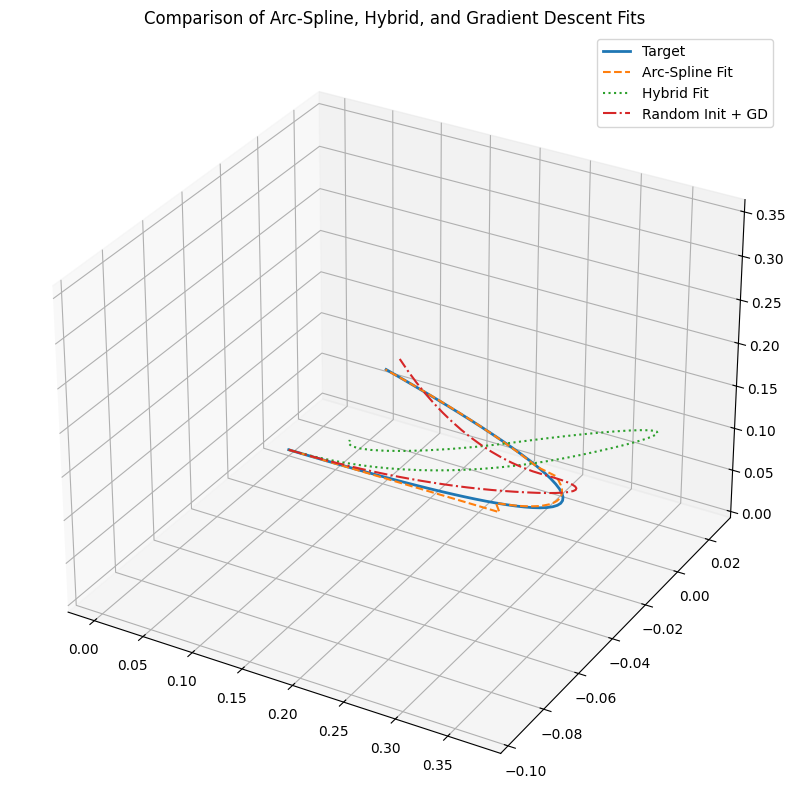

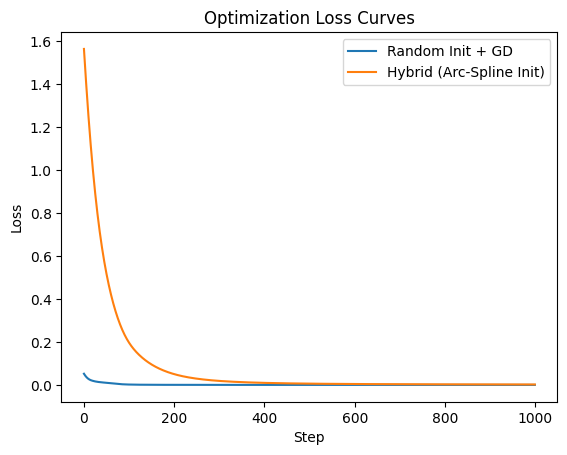

In [66]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot(pTarget_np[:,0], pTarget_np[:,1], pTarget_np[:,2], label='Target', lw=2)
ax.plot(fit_points[:,0], fit_points[:,1], fit_points[:,2], '--', label='Arc-Spline Fit')
ax.plot(p_hybrid[:,0], p_hybrid[:,1], p_hybrid[:,2], ':', label='Hybrid Fit')
ax.plot(p_random[:,0], p_random[:,1], p_random[:,2], '-.', label='Random Init + GD')
ax.legend()
ax.set_title('Comparison of Arc-Spline, Hybrid, and Gradient Descent Fits')
plt.show()

plt.figure()
plt.plot(losses_random, label='Random Init + GD')
plt.plot(losses_hybrid, label='Hybrid (Arc-Spline Init)')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.title('Optimization Loss Curves')
plt.show()

Print Summary Table

In [67]:
print("========= SUMMARY =========")
print(f"Direct Arc-Spline:   Error = {direct_error:.6f},   Time = {direct_time:.3f} s")
print(f"Hybrid (Spline+GD):  Error = {hybrid_error:.6f},   Time = {hybrid_time:.3f} s")
print(f"Random Init + GD:    Error = {random_error:.6f},   Time = {random_time:.3f} s")

========= SUMMARY =========
Direct Arc-Spline:   Error = 0.004268,   Time = 0.038 s
Hybrid (Spline+GD):  Error = 0.036638,   Time = 2.073 s
Random Init + GD:    Error = 0.004757,   Time = 0.387 s


In [ ]:
print("========== Summary ==========")
print(f"Direct Only      | Error: {direct_error:.6f} | Time: {direct_time:.3f} s")
print(f"Random + GD      | Error: {rand_error:.6f} | Time: {grad_time_rand:.3f} s")
print(f"Direct + GD      | Error: {hybrid_error:.6f} | Time: {grad_time_hybrid:.3f} s")

In [40]:
height = width = 1024
dt = 0.01

In [41]:
nDisks = 20
nSegments = 3

length = 0.1 * nSegments
radius = 0.05
fillRatio = 0.2
dx = length / ((nDisks + fillRatio - 1) * nSegments)

In [4]:
key = jax.random.PRNGKey(0)
params = 2 * jax.random.normal(key, (nSegments, 3))

optimizer = opt.adam(learning_rate=1e-2)
optState = optimizer.init(params)
criterion = jax.jit(jax.value_and_grad(l2Distance, 0))
pTarget = resampleUniform(CurveGenerator(nCtrl=3, order=2, nPoints=100, seed=400), 50)/2
p = resampleUniform(generateArcSpline(params, 1000), len(pTarget))
loss = []

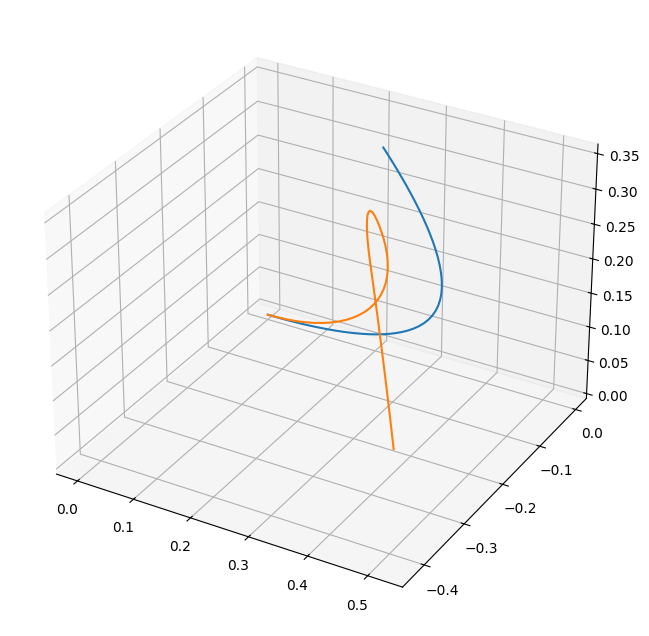

In [5]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(pTarget[:,0], pTarget[:,1], pTarget[:,2])
ax.plot(p[:,0], p[:,1], p[:,2])

Iteration 005248, Loss: 0.000003

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



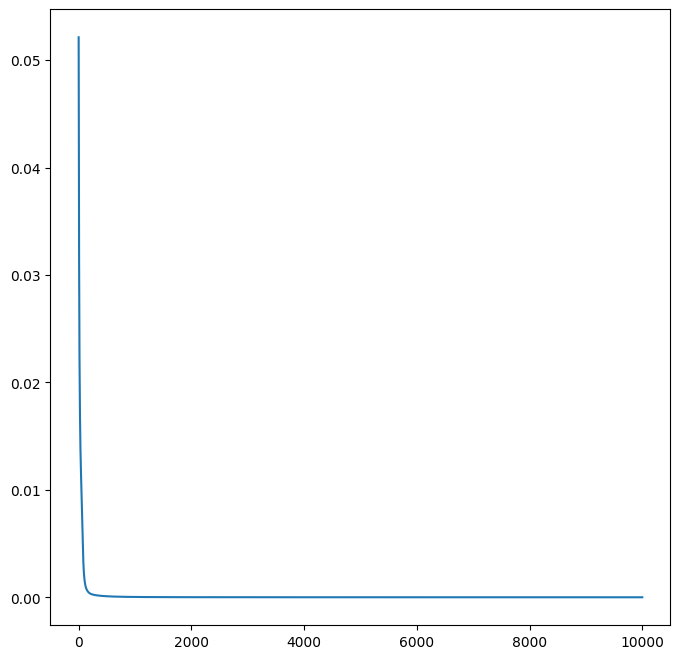

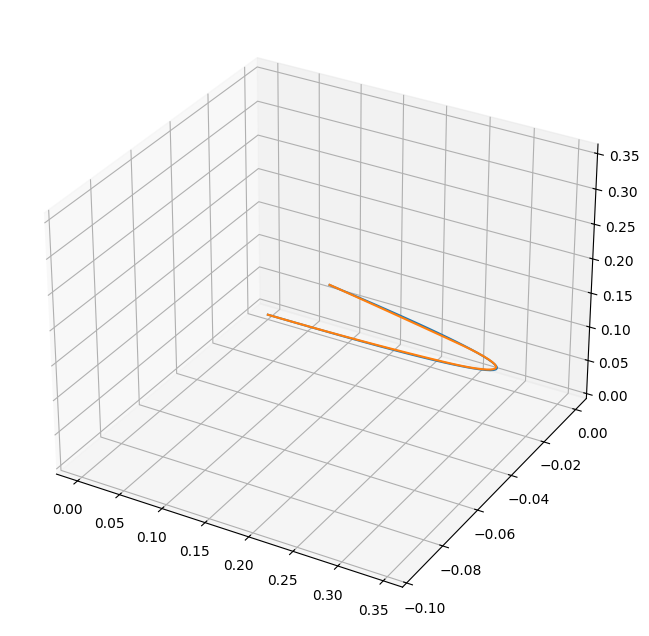

In [6]:
for ii in range(10000):
    L, params, optState = optimizationStep(params, pTarget, criterion, optimizer, optState)
    loss.append(L)
    print(f"Iteration {ii:06d}, Loss: {L:.6f}", end='\r', flush=True)

p = resampleUniform(generateArcSpline(params, 1000), len(pTarget))

fig = plt.figure(figsize=(8,8))
plt.plot(loss)
plt.show()

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(pTarget[:,0], pTarget[:,1], pTarget[:,2])
ax.plot(p[:,0], p[:,1], p[:,2])

In [7]:
innerStiffness = 0
innerDamping = 10

outerStiffness = 25
outerDamping = 3

force = 10

""

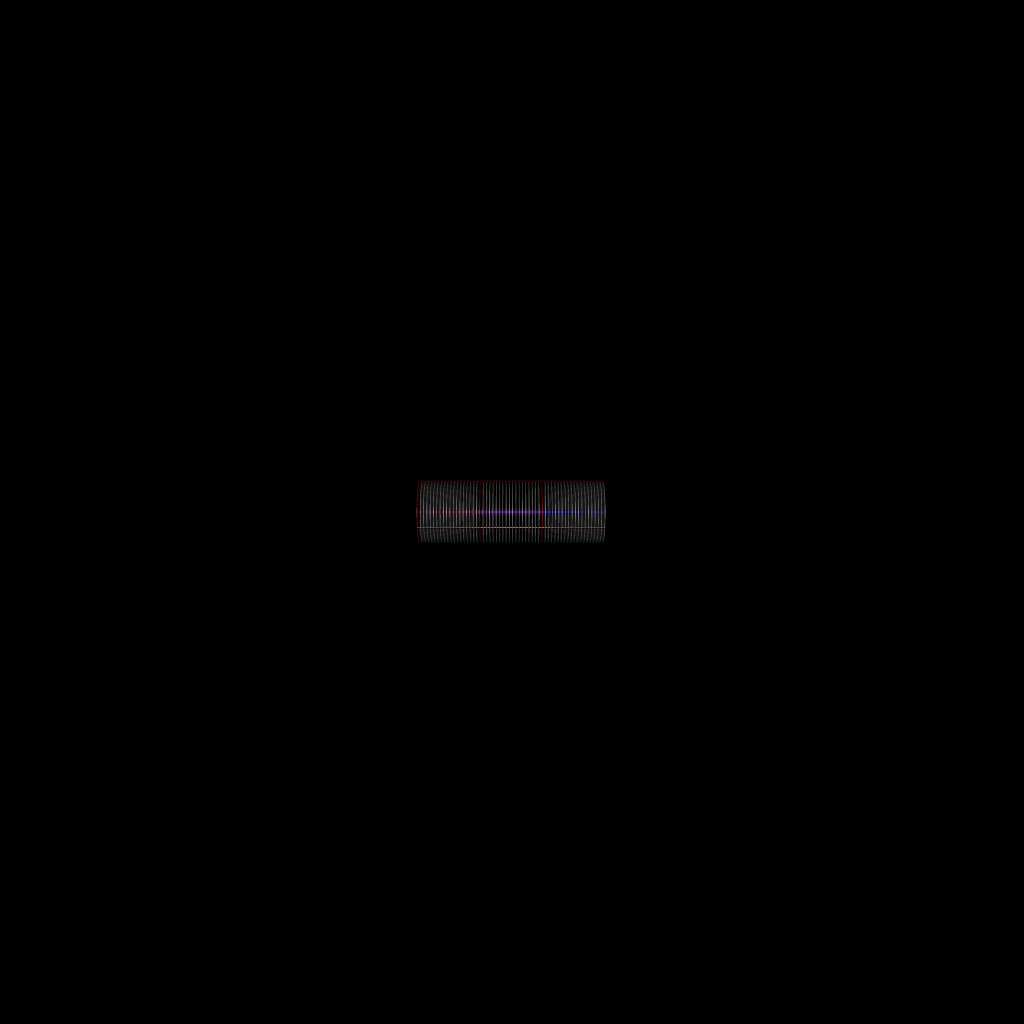

In [9]:
actuator3 = softActuator(nSegments= nSegments,
                         nDisks = nDisks,
                         length = length,
                         radius = radius,
                         innerStiffness = innerStiffness,
                         innerDamping = innerDamping,
                         outerStiffness = outerStiffness,
                         outerDamping = outerDamping,
                         gear = force,
                         mass = 0.1,
                         timeStep = dt,
                         fillRatio=fillRatio)
with mujoco.Renderer(actuator3.model, height, width) as renderer:
    renderer.update_scene(actuator3.data, camera='mainCamera')
    imRef = renderer.render()
media.show_image(imRef)

In [10]:
params_ = np.array((maxValue - minValue) * jnp.tanh(params) / 2 + (maxValue + minValue) / 2)
params_[:, -1] = np.cumsum(params_[:, -1])
percentage = np.zeros((nSegments, 3))
for ii in range(nSegments):
    percentage[ii] = calculateStiffness(params_[ii], dx, dx, dx, dx, innerStiffness, force, nDisks, radius)/outerStiffness

In [12]:
params_

array([[0.23358113, 0.26481956, 1.8217009 ],
       [0.24238282, 1.5552454 , 1.8385891 ],
       [0.16307688, 0.3287872 , 8.065028  ]], dtype=float32)

In [13]:
percentage

array([[0.96680966, 1.09405521, 0.92536574],
       [0.81247607, 1.95518938, 0.67287661],
       [1.973477  , 2.7505245 , 1.74708193]])

In [14]:
duration = 10 # (seconds)
framerate = 60  # (fps)


# Simulate and display video.
frames = []
ii = 0
actuator3.reset()
for kk in range(nSegments):
    for jj in range(3):
        actuator3.setStiffness(kk, jj, percentage[kk, jj])
with mujoco.Renderer(actuator3.model, height, width) as renderer:
    while np.round(actuator3.data.time, 1-int(np.log10(dt))) <= duration:
        actuator3.step(1)
        if len(frames) < actuator3.data.time * framerate:
            renderer.update_scene(actuator3.data, camera='mainCamera')
            frame = renderer.render()
            frames.append(frame)
        ii += 1

In [16]:
media.show_video(frames, fps=framerate)

In [14]:
p_ = actuator3.data.site_xpos.reshape(-1, 4, 3)[:, 0]

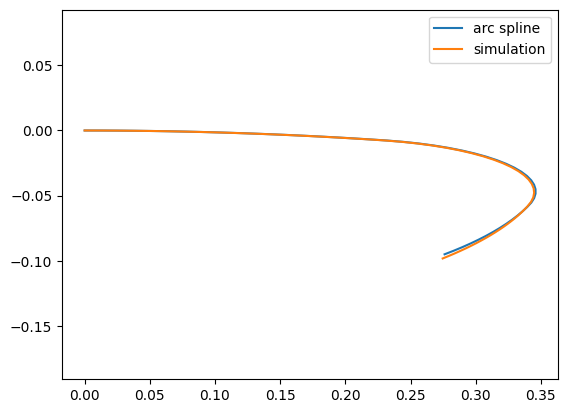

In [15]:
plt.axis('equal')
plt.plot(p[:,0], p[:,1], label='arc spline')
plt.plot(p_[:,0], p_[:,1], label='simulation')
plt.legend()
plt.show()

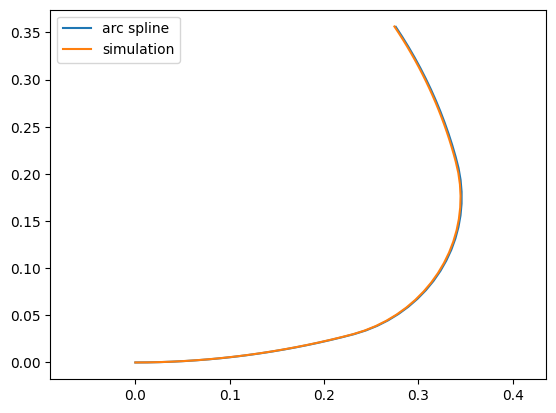

In [16]:
plt.axis('equal')
plt.plot(p[:,0], p[:,2], label='arc spline')
plt.plot(p_[:,0], p_[:,2], label='simulation')
plt.legend()
plt.show()

In [20]:
def set_axes_equal(ax):
    """
    Make x, y, z axes of a 3-D plot have the same scale
    so a unit cube looks like a cube.
    """
    # current limits
    xlim = ax.get_xlim3d()
    ylim = ax.get_ylim3d()
    zlim = ax.get_zlim3d()

    rng   = np.array([xlim, ylim, zlim])
    mids  = rng.mean(axis=1)
    radius = 0.5 * np.max(rng[:,1] - rng[:,0])

    ax.set_xlim3d(mids[0] - radius, mids[0] + radius)
    ax.set_ylim3d(mids[1] - radius, mids[1] + radius)
    ax.set_zlim3d(mids[2] - radius, mids[2] + radius)

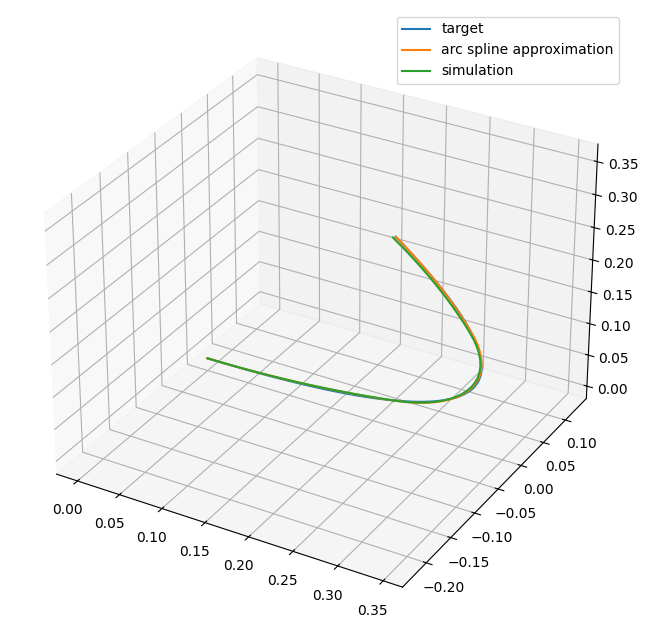

In [23]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(pTarget[:,0], pTarget[:,1], pTarget[:,2], label='target')
ax.plot(p[:,0], p[:,1], p[:,2], label='arc spline approximation')
ax.plot(p_[:,0], p_[:,1], p_[:,2], label='simulation')
set_axes_equal(ax)
ax.legend()
plt.show()